In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl

# set font to 9
mpl.rcParams.update({'font.size': 8})


# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 0.5

mpl.rcParams.update({
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,
})

In [3]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 53.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


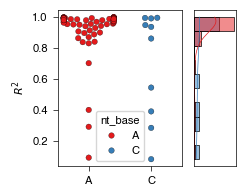

In [4]:
query= """SELECT
    log_kobs,
    log_kdeg,
    r2,
    nt_base,
    nt_site,
    construct_name
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained'
AND construct_name in ('4U_wt', '4U_a8c')
AND temperature = 25;
"""

df = read_sql(query)

# filter r2 > 0
df = df[df['r2'] > 0]

df_melted = df.melt(id_vars=['nt_base', 'nt_site', 'construct_name'], value_vars=['log_kobs', 'log_kdeg', 'r2'], var_name='parameter', value_name='value')

# sort by base
bases = ['A', 'C']
df_melted['nt_base'] = pd.Categorical(df_melted['nt_base'], categories=bases, ordered=True)

# swarmplot for r2
fig, axs = plt.subplots(1, 2, figsize=(2.5, 2), sharey = True, gridspec_kw={'width_ratios': [3, 1]})

r2_toplot = df_melted[df_melted['parameter'] == 'r2']
sns.swarmplot(data=r2_toplot, x='nt_base', y='value', hue='nt_base', palette = 'Set1', dodge = False, size = 4, edgecolor = 'k', linewidth = 0.2, ax = axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel(r'$R^2$')
# plot histogram on axs[1]
sns.histplot(data=r2_toplot, y='value', hue='nt_base', palette = 'Set1', bins = 10, stat='proportion', linewidth = 0.5, common_norm=False, kde = True, alpha = 0.5, ax = axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')

# remove ticks x and y
axs[1].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

# remove legend from axs[1]
axs[1].get_legend().remove()

plt.tight_layout()
plt.savefig('r2_swarm_hist_rd3_AC_4U25C.pdf')
plt.show()

In [11]:
r2_toplot

,nt_base,nt_site,construct_name,parameter,value
486,NaN,5,4U_a8c,r2,0.509659
487,NaN,6,4U_a8c,r2,0.851432
488,A,7,4U_a8c,r2,0.979538
489,NaN,10,4U_a8c,r2,0.104294
490,NaN,11,4U_a8c,r2,0.381533
...,...,...,...,...,...
724,NaN,27,4U_wt,r2,0.544932
725,NaN,28,4U_wt,r2,0.458554
726,NaN,30,4U_wt,r2,0.763366
727,NaN,31,4U_wt,r2,0.671473


In [12]:
df
r2_toplot = r2_toplot.dropna(subset=['nt_base'])
# count how many r2 > 0.8 in total
r2_high = r2_toplot[r2_toplot['value'] > 0.8]
r2_high_count = r2_high.shape[0]
r2_total_count = r2_toplot.shape[0]
print(f'Number of r2 > 0.8: {r2_high_count} out of {r2_total_count}')
print(f'Percentage of r2 > 0.8: {r2_high_count / r2_total_count * 100:.2f}%')

Number of r2 > 0.8: 68 out of 76
Percentage of r2 > 0.8: 89.47%


/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_20388/2934949668.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logkobs_toplot['kobs'] = np.exp(logkobs_toplot['value'])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


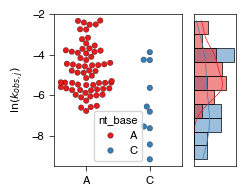

In [13]:
# swarmplot for log_kobs
fig, axs = plt.subplots(1, 2, figsize=(2.5, 2), sharey = True, gridspec_kw={'width_ratios': [3, 1]})

logkobs_toplot = df_melted[df_melted['parameter'] == 'log_kobs']
logkobs_toplot['kobs'] = np.exp(logkobs_toplot['value'])
sns.swarmplot(data=logkobs_toplot, x='nt_base', y='value', hue='nt_base', palette = 'Set1', dodge = False, size = 4, edgecolor = 'k', linewidth = 0.2, ax = axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel(r'$\ln(k_{obs,j})$')

# plot histogram on axs[1]
sns.histplot(data=logkobs_toplot, y='value', hue='nt_base', palette = 'Set1', bins = 10, stat='proportion', linewidth = 0.5, common_norm=False, kde = True, alpha = 0.5, ax = axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')

# remove ticks x and y
axs[1].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

# remove legend from axs[1]
axs[1].get_legend().remove()

plt.tight_layout()
plt.savefig('rlnkobs_swarm_hist_rd3_AC_4U25C.pdf')
plt.show()